In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Source : https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
movies = movies.replace({np.nan: None})

movie_initial = movies

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


total of 20 unique genres from 22084 occurances.


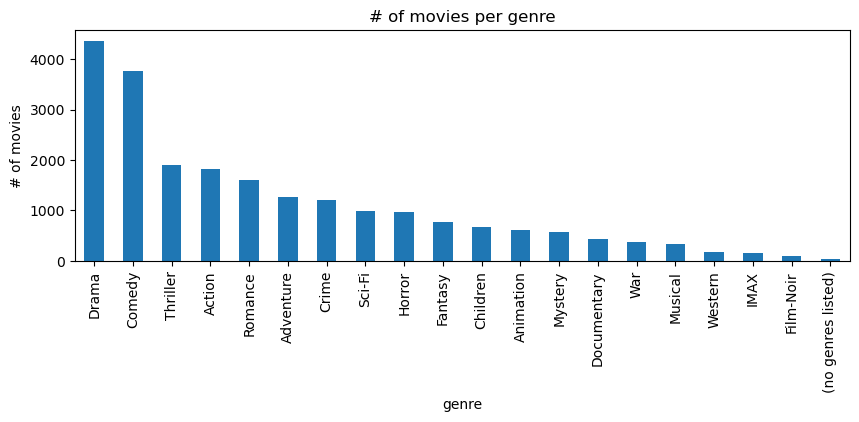

In [5]:
all_genres = [s.split("|") for s in movies[movies.genres.notnull()].genres]
genres = [item for l in all_genres for item in l ]
unique_genres = set(genres)
print (f"total of {len(unique_genres)} unique genres from {len(genres)} occurances.")

pd.Series(genres).value_counts().plot(kind='bar', figsize=(10, 3))
plt.title("# of movies per genre")
plt.ylabel("# of movies")
plt.xlabel("genre")
plt.show()

In [6]:
genres = [item.strip() for l in all_genres for item in l ]
unique_genres = set(genres)
for genre in unique_genres:
    movies[genre] = 0

movies.head()

,movieId,title,genres,Crime,Adventure,Thriller,War,Fantasy,Animation,Musical,...,Sci-Fi,Horror,Action,Romance,Documentary,Film-Noir,Drama,Children,IMAX,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
for i in range(len(movies)):
    if type(movies['genres'].iloc[i]) != None.__class__:
        Genres = movies.iloc[i].genres.split('|')
        for g in Genres:
            movies[g].iloc[i] = 1

movies.head()

/tmp/ipykernel_214/3815383559.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies[g].iloc[i] = 1


,movieId,title,genres,Crime,Adventure,Thriller,War,Fantasy,Animation,Musical,...,Sci-Fi,Horror,Action,Romance,Documentary,Film-Noir,Drama,Children,IMAX,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
movies = movies.drop(columns=['title', 'genres']).set_index('movieId')

movies.sort_index(axis=0, inplace=True)
movies.head()

,Crime,Adventure,Thriller,War,Fantasy,Animation,Musical,Western,(no genres listed),Mystery,Sci-Fi,Horror,Action,Romance,Documentary,Film-Noir,Drama,Children,IMAX,Comedy
movieId,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
user_x_movie = pd.pivot_table(ratings, values='rating', index=['movieId'], columns = ['userId'])
user_x_movie.sort_index(axis=0, inplace=True)


#Make all the NA values as 0 (i.e the places where user has not rated a movie)
user_x_movie.fillna(0,inplace=True)
user_x_movie

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Use tqdm to visualize the iterations over each genre
from tqdm import tqdm

userIDs = user_x_movie.columns
user_profile = pd.DataFrame(columns = movies.columns)

#Calculate the Users's preference of each genre in any movie
for i in tqdm(range(len(user_x_movie.columns))):
    working_df = movies.mul(user_x_movie.iloc[:,i], axis=0)
    user_profile.loc[userIDs[i]] = working_df.mean(axis=0)

100%|██████████| 610/610 [00:03<00:00, 165.50it/s]


In [11]:
user_profile

,Crime,Adventure,Thriller,War,Fantasy,Animation,Musical,Western,(no genres listed),Mystery,Sci-Fi,Horror,Action,Romance,Documentary,Film-Noir,Drama,Children,IMAX,Comedy
1,0.020156,0.038359,0.023447,0.010181,0.020773,0.013986,0.010592,0.003085,0.0,0.007713,0.017380,0.006067,0.040004,0.011518,0.000000,0.000514,0.031674,0.019642,0.000000,0.036508
2,0.003908,0.001285,0.003805,0.000463,0.000000,0.000000,0.000000,0.000360,0.0,0.000823,0.001594,0.000309,0.004473,0.000463,0.001337,0.000000,0.006787,0.000000,0.001543,0.002879
3,0.000103,0.003085,0.002982,0.000257,0.001388,0.000206,0.000051,0.000000,0.0,0.000514,0.006479,0.003856,0.005142,0.000257,0.000000,0.000000,0.001234,0.000257,0.000000,0.000926
4,0.010592,0.010901,0.013883,0.002571,0.007199,0.002468,0.006582,0.003908,0.0,0.008227,0.003497,0.001748,0.008536,0.020156,0.000823,0.001645,0.042986,0.003908,0.000309,0.037536
5,0.004731,0.002674,0.003291,0.001028,0.002982,0.002674,0.002262,0.000617,0.0,0.000411,0.000514,0.000309,0.002879,0.003497,0.000000,0.000000,0.009770,0.003805,0.001131,0.005348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.049979,0.052962,0.072141,0.025350,0.035891,0.016043,0.016865,0.005965,0.0,0.035479,0.028898,0.017894,0.049362,0.136569,0.001954,0.003137,0.271905,0.017380,0.005039,0.154360
607,0.010592,0.016043,0.025812,0.002571,0.007713,0.002057,0.001851,0.000823,0.0,0.008124,0.012032,0.014809,0.027561,0.010490,0.000000,0.000000,0.033834,0.006684,0.000514,0.018819
608,0.054247,0.059955,0.094200,0.006993,0.034245,0.017637,0.009358,0.002982,0.0,0.025195,0.056613,0.033114,0.094868,0.031469,0.001851,0.001543,0.098982,0.022265,0.004936,0.099907
609,0.002160,0.003291,0.004731,0.001440,0.000309,0.000309,0.000000,0.000411,0.0,0.000000,0.001543,0.000720,0.003497,0.001645,0.000617,0.000000,0.006582,0.000617,0.000309,0.002365


In [12]:
# We first calculate the document frequency (df) the number of terms(in this case genres) within all movies
df = movies.sum()

# We then calculate Inverse document frequency (IDF) which measures the importance of each term (in this case genre) 
# within all movies  
idf = (len(movies)/df).apply(np.log)

print("\nDocument Frequency : \n",df,"\n\nInverse Document Frequency : \n",idf,"\n")


Document Frequency : 
 Crime                 1199
Adventure             1263
Thriller              1894
War                    382
Fantasy                779
Animation              611
Musical                334
Western                167
(no genres listed)      34
Mystery                573
Sci-Fi                 980
Horror                 978
Action                1828
Romance               1596
Documentary            440
Film-Noir               87
Drama                 4361
Children               664
IMAX                   158
Comedy                3756
dtype: int64 

Inverse Document Frequency : 
 Crime                 2.094959
Adventure             2.042957
Thriller              1.637755
War                   3.238781
Fantasy               2.526191
Animation             2.769105
Musical               3.373061
Western               4.066208
(no genres listed)    5.657841
Mystery               2.833316
Sci-Fi                2.296649
Horror                2.298692
Action            

In [13]:
#We now calculate TF-IDF which is the weight of each term(genre) within each movie
TFIDF = movies.mul(idf.values)
TFIDF

,Crime,Adventure,Thriller,War,Fantasy,Animation,Musical,Western,(no genres listed),Mystery,Sci-Fi,Horror,Action,Romance,Documentary,Film-Noir,Drama,Children,IMAX,Comedy
movieId,,,,,,,,,,,,,,,,,,,,
1,0.0,2.042957,0.0,0.0,2.526191,2.769105,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,2.68592,0.0,0.953092
2,0.0,2.042957,0.0,0.0,2.526191,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,2.68592,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.808946,0.0,0.0,0.000000,0.00000,0.0,0.953092
4,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.808946,0.0,0.0,0.803745,0.00000,0.0,0.953092
5,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.953092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.000000,0.0,0.0,2.526191,2.769105,0.0,0.0,0.0,0.0,0.0,0.0,1.673224,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.953092
193583,0.0,0.000000,0.0,0.0,2.526191,2.769105,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.953092
193585,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.803745,0.00000,0.0,0.000000


In [14]:
#We now calculate the sum product of the importance weights and users’ preferences towards different genres 

df_predict = pd.DataFrame()

for i in tqdm(range(len(user_x_movie.columns))):
    working_df = TFIDF.mul(user_profile.iloc[i], axis=1)
    df_predict[user_x_movie.columns[i]] = working_df.sum(axis=1) 

 13%|█▎        | 79/610 [00:00<00:01, 392.16it/s]/tmp/ipykernel_214/3839409207.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[user_x_movie.columns[i]] = working_df.sum(axis=1)
/tmp/ipykernel_214/3839409207.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[user_x_movie.columns[i]] = working_df.sum(axis=1)
/tmp/ipykernel_214/3839409207.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [15]:
df_predict

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.257124,0.005371,0.011952,0.093561,0.035717,0.167487,0.097899,0.025238,0.018216,0.094271,...,0.118148,0.048139,0.230575,0.054178,0.282867,0.437089,0.093845,0.412854,0.012268,0.628943
2,0.183600,0.002626,0.010501,0.050951,0.023216,0.109304,0.069180,0.016267,0.011686,0.052467,...,0.082283,0.032922,0.122745,0.038130,0.232658,0.245545,0.070213,0.268795,0.009160,0.405310
3,0.055630,0.003582,0.001347,0.072237,0.011422,0.089015,0.029982,0.016663,0.008925,0.073655,...,0.021549,0.028006,0.243859,0.017213,0.064979,0.394166,0.036912,0.152146,0.005231,0.232902
4,0.081088,0.009037,0.002339,0.106787,0.019274,0.130839,0.044736,0.022614,0.014877,0.092418,...,0.039486,0.046521,0.405286,0.028454,0.080188,0.612708,0.064105,0.231702,0.010521,0.386311
5,0.034795,0.002744,0.000882,0.035775,0.005097,0.041950,0.015192,0.007547,0.005391,0.025288,...,0.008527,0.012938,0.105267,0.009213,0.028424,0.147120,0.017937,0.095221,0.002254,0.150305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.192937,0.010230,0.013562,0.075077,0.024853,0.121831,0.082911,0.019231,0.013430,0.072661,...,0.085997,0.047781,0.234842,0.046659,0.201503,0.364805,0.089231,0.389305,0.009738,0.684880
193583,0.126001,0.002744,0.004959,0.060795,0.020035,0.082083,0.047034,0.012348,0.009128,0.057002,...,0.058207,0.021971,0.151215,0.026699,0.163217,0.282210,0.043116,0.230569,0.003888,0.364569
193585,0.025458,0.005455,0.000992,0.034550,0.007852,0.041824,0.014754,0.005951,0.005951,0.018763,...,0.017936,0.018515,0.161427,0.011241,0.015209,0.218542,0.027194,0.079556,0.005290,0.153409


In [23]:
def recommender(user_no):
    # User predicted rating to all films
    user_predicted_rating = df_predict[df_predict.columns[user_no - 1]]

    # Combining film rating and film detail
    user_rating_film = pd.merge(user_predicted_rating, movie_initial, left_on='movieId', right_on='movieId')

    # Films already watched by user
    already_watched = ratings[ratings['userId'].isin([user_no])]['movieId']

    # Recommendation without films being watched by user
    all_rec = user_rating_film[~user_rating_film.index.isin(already_watched)]

    # Sort the recommendations based on predicted ratings
    sorted_rec = all_rec.sort_values(by=[user_no], ascending=False).iloc[0:10]

    # Add actual ratings for the recommended movies
    recommended_movies = pd.merge(sorted_rec, ratings[['movieId', 'rating']], on='movieId', how='left')
    
    return recommended_movies[['movieId', 'title', 'rating']]

In [17]:
#Here are some examples where we are given 10 recommendations once we enter a give userID

In [24]:
recommender(600)

,movieId,title,rating
0,56152,Enchanted (2007),3.0
1,56152,Enchanted (2007),4.0
2,56152,Enchanted (2007),4.0
3,56152,Enchanted (2007),4.5
4,56152,Enchanted (2007),3.0
...,...,...,...
349,32031,Robots (2005),3.5
350,32031,Robots (2005),3.0
351,32031,Robots (2005),4.0
352,32031,Robots (2005),2.5


In [25]:
recommender(400)

,movieId,title,rating
0,79132,Inception (2010),4.0
1,79132,Inception (2010),3.5
2,79132,Inception (2010),3.0
3,79132,Inception (2010),4.5
4,79132,Inception (2010),4.5
...,...,...,...
322,49530,Blood Diamond (2006),3.0
323,49530,Blood Diamond (2006),2.5
324,49530,Blood Diamond (2006),1.0
325,49530,Blood Diamond (2006),3.5


In [26]:
recommender(267)

,movieId,title,rating
0,71999,Aelita: The Queen of Mars (Aelita) (1924),4.5
1,36509,"Cave, The (2005)",2.0
2,36509,"Cave, The (2005)",3.5
3,36509,"Cave, The (2005)",2.5
4,164226,Maximum Ride (2016),4.5
...,...,...,...
197,117529,Jurassic World (2015),3.5
198,117529,Jurassic World (2015),2.0
199,117529,Jurassic World (2015),3.5
200,27618,"Sound of Thunder, A (2005)",3.5


RMSE: 0.00
